In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset

import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, IntegratedGradients, GradientShap

from functools import partial

from CustomCNNVessel import CustomResNet

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cpu")

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.pairs = self._find_pairs(image_dir, mask_dir)

    def _find_pairs(self, image_dir, mask_dir):
        pairs = []
        for img_file in os.listdir(image_dir):
            base_name = os.path.splitext(img_file)[0]
            mask_file = os.path.join(mask_dir, base_name + '.png')
            if os.path.exists(mask_file):
                pairs.append(img_file)
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file = self.pairs[idx]
        image_path = os.path.join(self.image_dir, img_file)
        base_name = os.path.splitext(img_file)[0]
        mask_path = os.path.join(self.mask_dir, base_name + '.png')

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((448, 448)),
]) 

# Paths to your image and mask directories
image_dir = "./data/images/"
mask_dir = './data/labels/'

# Create the dataset
dataset = SegmentationDataset(image_dir, mask_dir, transform)


dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # e.g., 80% for training
val_size = dataset_size - train_size

# Split the dataset
train_dataset, train_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

In [4]:
test_loader = DataLoader(dataset, batch_size=8, shuffle=False)

# Select a random batch from the test dataset
images, masks = next(iter(test_loader))

In [5]:
class SegmentationAttribution:
    def __init__(self, model, images, masks=None, device="cpu"):
        self.model = model.to(device)
        self.images = [img.to(device) for img in images]
        self.masks = masks
        self.device = device
        self.out_maxes = []

    def apply_model(self):
        for img in self.images:
            input_tensor = img.unsqueeze(0)
            output = self.model(input_tensor)
            out_max = torch.argmax(output, dim=1, keepdim=True)
            self.out_maxes.append(out_max)

    def agg_segmentation_wrapper(self, inp, out_max):
        model_out = self.model(inp)
        selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
        return (model_out * selected_inds).sum(dim=(2,3))

    def pixels_wrapper(self, inp,):
        model_out = self.model(inp)
        return (model_out[0:1, :, self.p_height, self.p_width])

    def compute_attributions(self, method, layer, tgt, n_steps=10, baselines=None, wrapper_type="agg", p_height = 14, p_width = 14):
        method_instance = {
            'LayerGradCam': LayerGradCam,
            'LayerActivation': LayerActivation,
            'FeatureAblation': FeatureAblation,
            'IntegratedGradients': partial(IntegratedGradients, multiply_by_inputs=False),
            'GradientShap': GradientShap
        }[method]

        #self.centroids = []
        if method == "IntegratedGradients":
            self.model.eval()
            if baselines is None:
                baselines = torch.zeros_like(self.images[0].unsqueeze(0))

        attrs = []
        for idx, (img, out_max) in enumerate(zip(self.images, self.out_maxes)):
            input_tensor = img.unsqueeze(0)

            if wrapper_type == "agg":
                wrapper_func = lambda inp: self.agg_segmentation_wrapper(inp, out_max)
            """ elif wrapper_type == "pix":
                if self.masks is not None:
                    mask = self.masks[idx].to(self.device)
                    p_width, p_height = self.find_centroid(mask)
                    self.centroids.append((p_width, p_height))
                else:
                    raise ValueError("Pixel coordinates (p_height, p_width) must be provided either directly or through a mask.")
                self.p_height = int(p_height)
                self.p_width = int(p_width)
                
                self.p_height = int(self.centroids[idx][0])
                self.p_width = int(self.centroids[idx][1])
                # Experimenting with black dot on the center
                input_tensor[:, :, p_height, p_width] = 0
                wrapper_func = self.pixels_wrapper """


            try:
                attr_method = method_instance(wrapper_func, layer)
            except:
                attr_method = method_instance(wrapper_func)
                

            if method == "FeatureAblation":
                attr = attr_method.attribute(input_tensor,
                                             feature_mask=out_max, 
                                             perturbations_per_eval=2, target=tgt)

            elif method == "IntegratedGradients":
                attr, _ = attr_method.attribute(input_tensor, 
                                                target=tgt, baselines=baselines, method='gausslegendre',
                                                return_convergence_delta=True, n_steps=n_steps)
                
            elif method == "LayerActivation":
                attr = attr_method.attribute(input_tensor)
                attr = attr[:, tgt, :, :].unsqueeze(0)

            elif method == "GradientShap":
                if baselines is None:
                    baselines = torch.zeros_like(self.images[0].unsqueeze(0))
                attr = attr_method.attribute(input_tensor, target=tgt, baselines=baselines)

            else:
                attr = attr_method.attribute(input_tensor, target=tgt)
                
            attrs.append(attr)
        return attrs
    
    def plot_attributions(self, attributions, wrapper_type="agg", save_path=None, title=None):
        num_images = len(self.images)
        num_rows = (num_images // 5) + int(num_images % 5 != 0)
        fig, axes = plt.subplots(nrows=num_rows, ncols=8, figsize=(20, num_rows * 4))  # 10 columns for 5 pairs of original and attribution images.

        # Ensure axes is always a 2D array, even if there's only one row
        if num_rows == 1:
            axes = [axes]

        for idx, (attr, img) in enumerate(zip(attributions, self.images)):
            row = idx // 4
            col = (idx % 4) * 2  # Multiplying by 2 to accommodate both the image and its attribution side by side

            # Original Image
            axes[row][col].imshow(img.cpu().numpy().transpose(1, 2, 0), cmap='gray')
            if wrapper_type == "pix":
                axes[row][col].scatter(*self.centroids[idx], marker='.', c='red', s=3)
            axes[row][col].set_title("Original Image")
            
            axes[row][col].axis('off')

            # Attribution Map
            im = axes[row][col+1].imshow(attr[0].cpu().permute(1,2,0).detach().numpy(), cmap='RdYlGn')
            """ if wrapper_type == "pix":
                centroid_title = f"Attribution Map\nCentroid: {self.centroids[idx]}"
                #axes[row][col+1].scatter(*self.centroids[idx], marker='.', c='red', s=3)
                
            else:
                centroid_title = "Attribution Map"
            axes[row][col+1].set_title(centroid_title) """
            axes[row][col+1].set_title("Attribution Map")
            axes[row][col+1].axis('off')

            # Colorbar
            divider = make_axes_locatable(axes[row][col+1])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, ax=axes[row][col+1], cax=cax, orientation='vertical')

        if title:
            fig.suptitle(title, fontsize=16)

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.tight_layout()
        plt.show()

In [6]:
dataset_type = 'vessel'


model = CustomResNet(num_classes=2).to(device)
# Load the weights
model.load_state_dict(torch.load(f"./Models/custom_cnn_{dataset_type}_2.pth"))
model.eval()  # Set the model to evaluation mode

input_images = images[:10] # List of images

target = 1
p_height = 14
p_width = 14

seg_attr = SegmentationAttribution(model, input_images, masks)
seg_attr.apply_model()

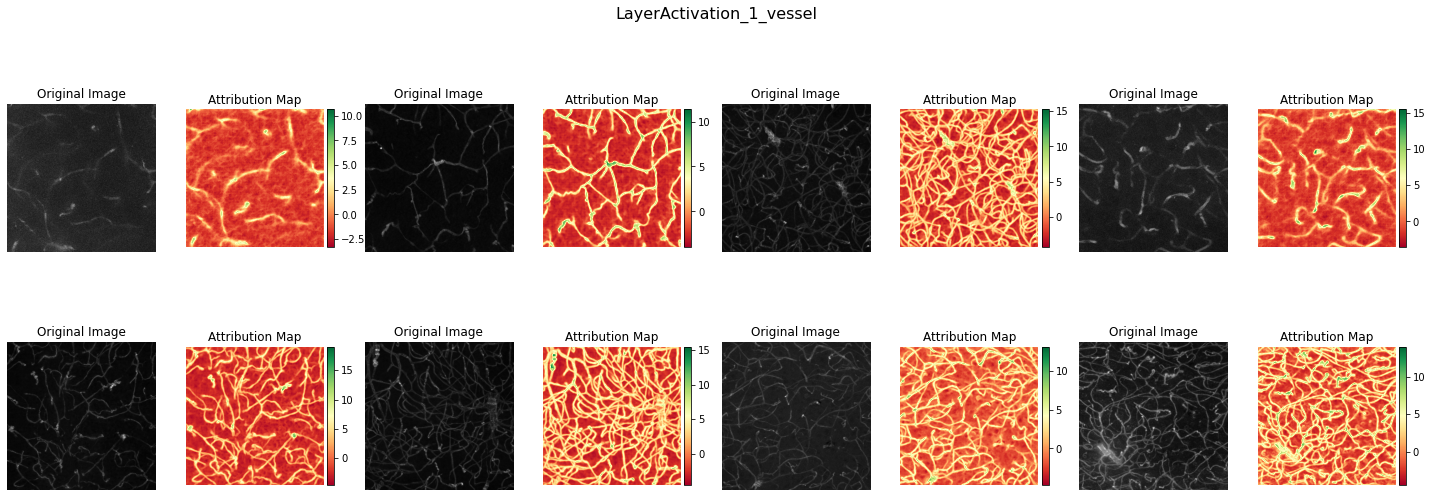

In [7]:
path = "AttributionsMaps/Vessel/"
# Usage
attributions = seg_attr.compute_attributions('LayerActivation', 
                                             model.final, 
                                             tgt=target)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}LayerActivation_{target}_{dataset_type}",
                           title=f"LayerActivation_{target}_{dataset_type}") #method_target

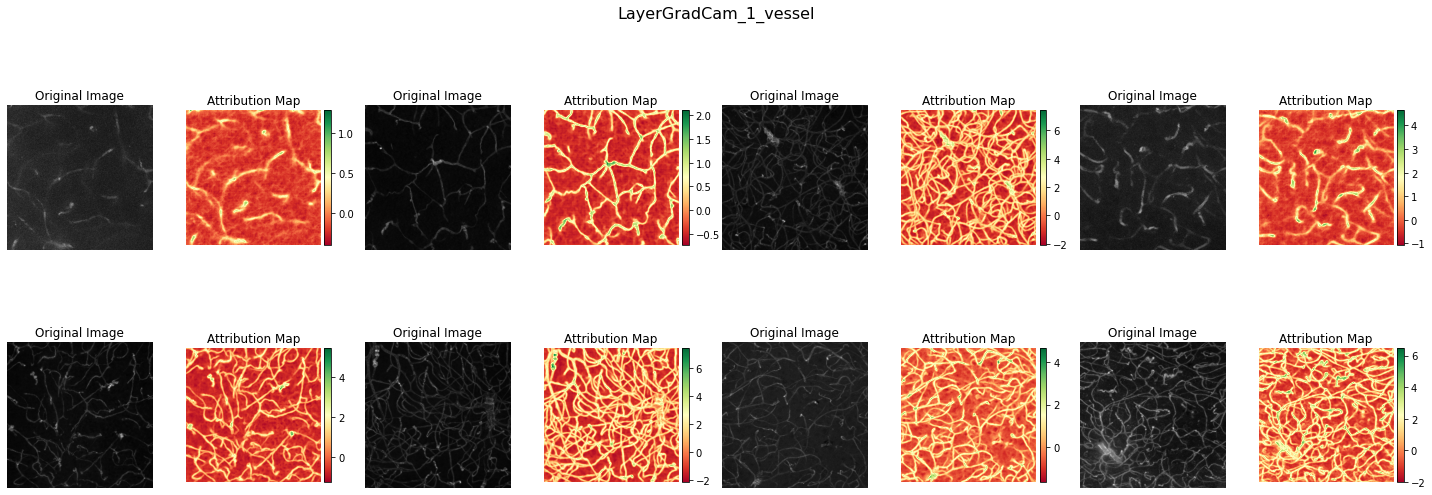

In [8]:
attributions = seg_attr.compute_attributions('LayerGradCam', 
                                             model.final, 
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}LayerGradCam_{target}_{dataset_type}",
                           title=f"LayerGradCam_{target}_{dataset_type}") #method_target

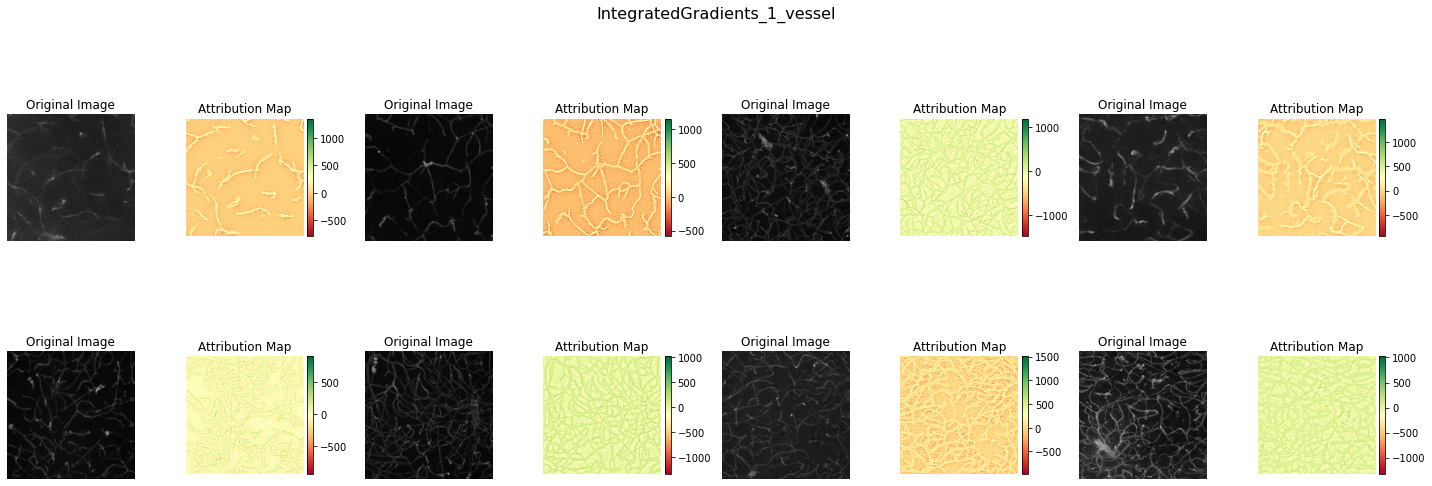

In [9]:
# Usage
attributions = seg_attr.compute_attributions('IntegratedGradients', 
                                             model.final, 
                                             n_steps=10,
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}IntegratedGradients_{target}_{dataset_type}",
                           title=f"IntegratedGradients_{target}_{dataset_type}") #method_target

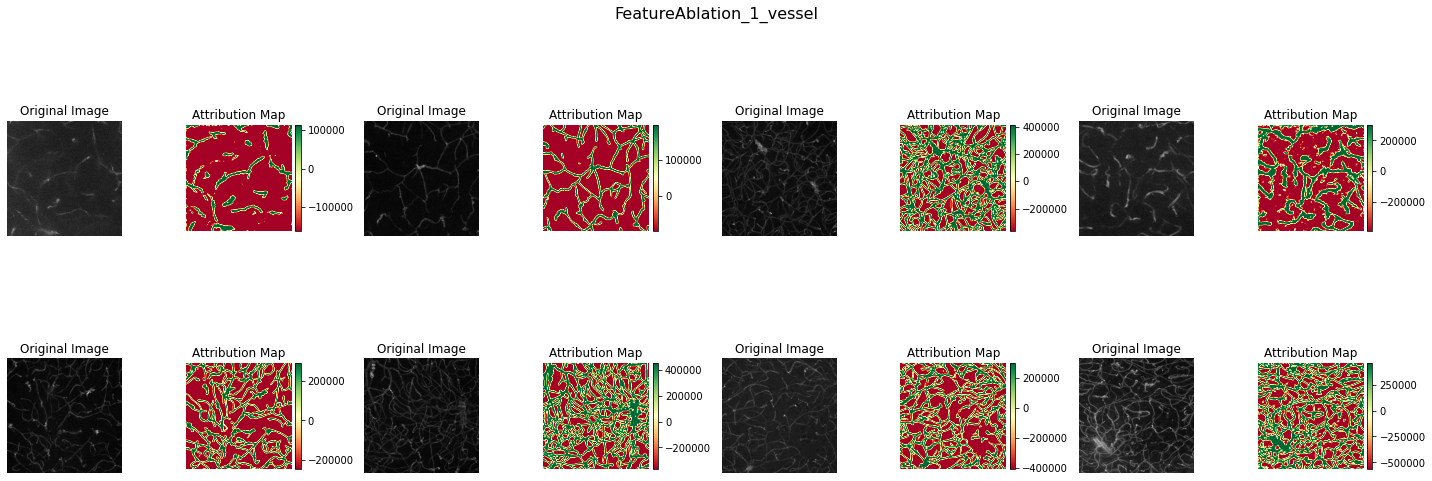

In [10]:
# Usage
attributions = seg_attr.compute_attributions('FeatureAblation', 
                                             model.final, 
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}FeatureAblation_{target}_{dataset_type}",
                           title=f"FeatureAblation_{target}_{dataset_type}") #method_target

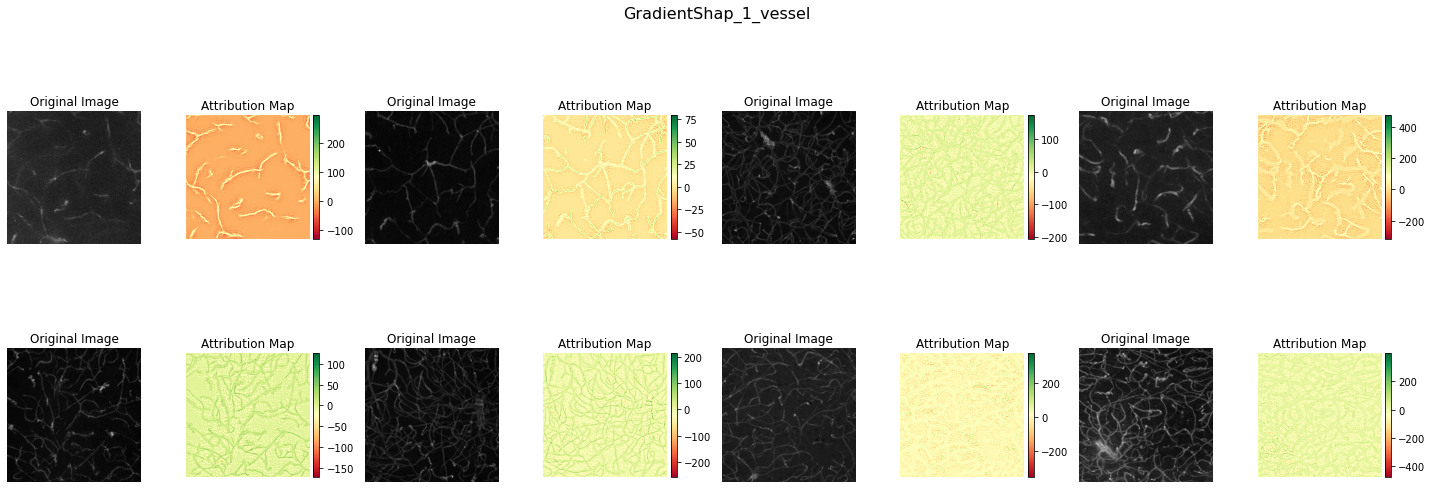

In [11]:
# Usage
attributions = seg_attr.compute_attributions('GradientShap', 
                                             model.final, 
                                             tgt=1)
seg_attr.plot_attributions(attributions, 
                           save_path=f"{path}GradientShap_{target}_{dataset_type}",
                           title=f"GradientShap_{target}_{dataset_type}") #method_target